**Problem**:

We need a good understanding of the T1DExi data. After having assessed the netiob script, and the study documentation some questions remain about how the columns relate. Especially the script often uses equivalent columns which makes it difficult. The analysis of the script output also leads to strong concerns about the validity of the output.

Questions we want to answer:
Do we need all the columns or are they mostly redundant?
Can we rely on the table as presented in T1DEXI ACRF_15Sept2022.pdf? or rather on the script?
The script sometimes uses FATEST (test) and FACAT (category) depending on which pump is being looked at 670g and 770g?
The script does not extract extended boluses in 770g, why?
Is FASTRESN just a copy of the value in INSEXBOL or INSNMBOL and FAORRES (Basal)?

we want to take a close look at the data itself.

**Goal**: Load xpt file into pandas in jupyter. Identify relevant columns and verify how they relate to another. For now, only for Insulin Data.

In [1]:
import os
import sys
sys.path.append('../..')

import matplotlib.pyplot as plt

from src import cdf

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import isodate

## Load the data
1. How many patients
2. Fraction per pump system

In [30]:
#define path
t1dexi_path = os.path.join(os.getcwd(),'..','..','data','raw','T1DEXI')

### load device file

In [31]:
#load and preprocess dx file
dx = pd.read_sas(os.path.join(t1dexi_path,'DX.xpt'),encoding='latin-1').replace('', np.nan)
dx = dx.drop(columns=['DXSCAT','DXPRESP','STUDYID','DOMAIN','SPDEVID','DXSEQ','DXCAT','DXSCAT','DXSTRTPT','DXDTC','DXENRTPT','DXEVINTX','VISIT'])
display(dx.sample(3))
#drop generic device codes that are duplicates of the true pump
#dx = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])]

,USUBJID,DXTRT
690,60,CLOSED LOOP INSULIN PUMP
680,576,MEDTRONIC 670G IN AUTO MODE
635,498,CLOSED LOOP INSULIN PUMP


### assess device counts and treatment types

In [32]:
#assess device counts and treatment types

#print dx value counts (subjects, devices)
print(f'There are {dx.USUBJID.nunique()} unique subjects in the dx dataset')
print('These are broken down by devices as follows:')
display(dx.value_counts('DXTRT'))


#the duplicated 'INSULIN PUMP' or 'CLOSED LOOP INSULIN PUMP' values can be used to specify the pump type
pump_type = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])][['USUBJID','DXTRT']]
mdi_type = dx.loc[dx.DXTRT.isin(['MULTIPLE DAILY INJECTIONS'])]
other_type = dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])]
print(f'Pump: {len(pump_type)}, MDI: {len(mdi_type)}, Other: {len(other_type)}')

#use the redundant rows as treatment type and add those to new TRTMNT Colum (CSII, AID, MDI)
treatment_type = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])][['USUBJID','DXTRT']].rename(columns={'DXTRT':'TRTMNT'})
treatment_type['TRTMNT'] = treatment_type.TRTMNT.replace({'INSULIN PUMP':'CSII','CLOSED LOOP INSULIN PUMP':'AID','MULTIPLE DAILY INJECTIONS':'MDI'})
treatment = pd.merge(dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])], treatment_type, on='USUBJID',how='inner')
treatment.value_counts(['TRTMNT','DXTRT'],sort=False)

There are 502 unique subjects in the dx dataset
These are broken down by devices as follows:


DXTRT
CLOSED LOOP INSULIN PUMP                     225
TANDEM T:SLIM X2 WITH CONTROL IQ             190
INSULIN PUMP                                 189
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM    106
MULTIPLE DAILY INJECTIONS                     88
MEDTRONIC 670G IN AUTO MODE                   33
TANDEM T:SLIM X2 WITH BASAL IQ                23
MEDTRONIC 670G IN MANUAL MODE                 21
MEDTRONIC 630G                                 9
TANDEM T:SLIM X2                               8
TANDEM T:SLIM                                  5
MEDTRONIC PARADIGM 723 (REVEL)                 4
MEDTRONIC 670G                                 3
MEDTRONIC 770G                                 2
MEDTRONIC 770G IN AUTO MODE                    2
MEDTRONIC 551 (530G)                           2
MEDTRONIC 751 (530G)                           2
MEDTRONIC PARADIGM 523 (REVEL)                 1
MEDTRONIC PARADIGM 522                         1
INSULET OMNIPOD DASH                           1
MEDTRONIC 640G

Pump: 414, MDI: 88, Other: 414


TRTMNT  DXTRT                                    
AID     MEDTRONIC 670G IN AUTO MODE                   32
        MEDTRONIC 770G                                 1
        MEDTRONIC 770G IN AUTO MODE                    2
        TANDEM T:SLIM X2 WITH CONTROL IQ             190
CSII    INSULET OMNIPOD DASH                           1
        INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM    106
        MEDTRONIC 551 (530G)                           2
        MEDTRONIC 630G                                 9
        MEDTRONIC 640G                                 1
        MEDTRONIC 670G                                 3
        MEDTRONIC 670G IN AUTO MODE                    1
        MEDTRONIC 670G IN MANUAL MODE                 21
        MEDTRONIC 751 (530G)                           2
        MEDTRONIC 770G                                 1
        MEDTRONIC PARADIGM 522                         1
        MEDTRONIC PARADIGM 523 (REVEL)                 1
        MEDTRONIC PARADIGM 723 (REVEL)


We can see some inconsistent classificaitons:  
 - 770G in the AID section is probably a 770G in Auto MODE
 - TANDEM T:SLIM X2 WITH BASAL IQ in the CSII are probably AID
 - MEDTRONIC 670G IN AUTO MODE in CSII are probably AID instead

So, can we trust this list? The netiob scripts made the following observation:  
>[Discretional]. We observed that subject ID: 766 device type should be 'MEDTRONIC 770G IN AUTO MODE' and we updated as such
        device_data.loc[device_data['USUBJID'] == '766', 'DXTRT'] = 'MEDTRONIC 770G IN AUTO MODE'

However, there are also many TANDEM with BASAL IQ, these could probbaly also be considered to be AID. Ultimately, the netiob script assigned the treatment based on the DXTRT name alone.   

**Conclusion**: ATM we don't know which one to use.

### Load FACM file

In [36]:
#load and preprocess facm file
facm = pd.read_sas(os.path.join(t1dexi_path,'FACM.xpt'),encoding='latin-1',).replace('', np.nan)

#'FAORRES','FASTRESC' and FASTRESN all show the finding (result) (however, 0 values show up as 5.397605e-79 in FASTRESN)
#`FAORRES`: Result or Finding in Original Units
#`FASTRESC`: Character Result/Finding in Std Format
#`FASTRESN`: Numeric Result/Finding in Standard Unit
facm['FAORRES'] = facm['FAORRES'].astype(float)

#FAORRESU and FASTRESU refer to the Unit but since U/hr is not a standard unit it is NaN in FASTRESU
#`FAORRESU`: Original Units
#`FASTRESU`: Standard Units
facm = facm.drop(columns=['STUDYID','DOMAIN','FASEQ',
                          'FASTRESN','FASTRESC',# Numeric results are 5.397605e-79 for 0 values, therefore use FAORRES (original units),FASTRESC is just a string duplicated
                          'FASTRESU', #standard units are NaN for U/hr , therefore use FAORRESU (original units)
                          ]) 

#alternatively we could use 
facm['FADTC'] = facm['FADTC'].apply(lambda x: datetime(1960, 1, 1) + timedelta(seconds=x) if pd.notnull(x) else pd.NaT)
facm['FADUR'] = facm.FADUR.dropna().apply(isodate.parse_duration, as_timedelta_if_possible=True)

#note, we didn't need to replace % signs and we didn't need xport as in the scripts
percent_count_facm = facm.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
percent_count_dx = dx.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
print(f'Number of % in facm: {percent_count_facm}, dx: {percent_count_dx}')

display(facm.sample(5))

Number of % in facm: 0, dx: 0


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL
1938100,773,INSBOLUS,BOLUS INSULIN,INSULIN,BOLUS,1.200,U,2020-09-09 19:37:06,NaT,Pump,normal,1.2,NaN
1423250,434,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.276,U/hr,2020-05-21 04:45:49,0 days 00:05:01,NaN,NaN,NaN,NaN
1681410,614,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.018,U,2020-02-29 09:12:32,0 days 00:05:00,Pump,temp,NaN,NaN
1294945,334,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.459,U/hr,2019-12-05 06:15:52,0 days 00:05:02,NaN,NaN,NaN,NaN
346692,1230,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.600,U/hr,2021-02-25 22:19:17,0 days 00:04:59,NaN,NaN,NaN,NaN


In [172]:
facm.count()-len(facm)

USUBJID           0
FATESTCD          0
FATEST            0
FAOBJ             0
FACAT             0
FAORRES      -30248
FAORRESU          0
FADTC             0
FADUR       -114473
INSDVSRC   -1053401
INSSTYPE   -1068093
INSNMBOL   -2136615
INSEXBOL   -2216541
DXTRT            -1
ISMDI             0
day               0
dtype: int64

- FAORRES has less values, this is because it is a "standard unit" which is Nan for non standard stuff like U/here
- FADUR is missing for boluses and basal deliveries (basal deliveries (non flow rates) are mostly set to 5 minutes)
- insulin type and source are often missing
- INSNMBOL and INSEXBOL are often missing (probably mostly for all the basal values)

### Merge devices to facm

In [37]:
## merge devices to facm 

#drop the generic device codes that are duplicates of the true pump before merging
temp = dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])]
facm = pd.merge(facm, temp, on='USUBJID',how='left')
display(facm.sample(2))

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,DXTRT
858458,1559,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.000,U,2019-09-21 12:23:20,0 days 00:24:55,Pump,temp,NaN,NaN,TANDEM T:SLIM X2 WITH CONTROL IQ
1369037,389,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.032,U,2019-10-18 09:21:03,0 days 00:05:01,Pump,temp,NaN,NaN,TANDEM T:SLIM X2 WITH CONTROL IQ


## Understand Basal and Boluses

### Inspect column hiarchy

In [38]:
#print hierachical value counts of relevant columns
print(f'Overall number of rows in FACM {facm.shape[0]}')

vcounts= facm.value_counts(subset=['FAOBJ','FACAT','FATESTCD','FATEST','INSDVSRC','INSSTYPE'],sort=False,dropna=False)
display(vcounts)

#We see that source and sub type are NaN when fatest is basal flow rate. So do the units differ?
vcounts = facm.value_counts(subset=['FATEST','INSDVSRC','FAORRESU'],sort=False,dropna=False)
display(vcounts)

Overall number of rows in FACM 2219524


FAOBJ    FACAT  FATESTCD  FATEST           INSDVSRC    INSSTYPE                  
INSULIN  BASAL  BASFLRT   BASAL FLOW RATE  NaN         NaN                           1053401
                INSBASAL  BASAL INSULIN    Injections  NaN                              2365
                                           Pump        automated                      237033
                                                       scheduled                      258749
                                                       suspend                         14457
                                                       temp                           537986
                                                       NaN                              2811
         BOLUS  INSBOLUS  BOLUS INSULIN    Injections  NaN                              9516
                                           Pump        automated                        1619
                                                       automatic bolus/correction

FATEST           INSDVSRC    FAORRESU
BASAL FLOW RATE  NaN         U/hr        1053401
BASAL INSULIN    Injections  U              2365
                 Pump        U           1051036
BOLUS INSULIN    Injections  U              9516
                 Pump        U            103206
Name: count, dtype: int64

Observations
 1. `FAOBJ` is always INSULIN and can be ignored
 2. `FACAT` separates between BOLUS and BASAL
 3. `FATESTCD` and `FATEST` have the same meaning (basal, basal flow rate and bolus), Use FATEST because it is more explicit
 3. `INSTYPE` is *NaN* when device Source (`INSDVSRC`) is *NaN* or *Injections* and for some Basals with Pump source

### Basal Rates vs. Basal Flow Rates

**Observations:**  
1. We see that there are Basal Rates and Basal Flow Rates. 
2. It is unclear if these are duplicates or if both need to be considered. 
3. The netiob script only considers FATEST == 'BASAL INSULIN' thus ignoring BASAL FLOW RATE. 
  - Is this correct?  
4. Also, we see that there Are Basal Flow Rates in MDI. 

**We want to check.**  
1. How often these are available (by device)
   - when dropping Nan FASTRESN rows
2. Do deliveries (U) modulate the flow rates (U/hr)?
 - Comparing sums (flow rates* duration  vs. basal deliveries)
3. Why there are BASAL FLOW Rates in MDI?

We start by checking if basal flow rates exist for all insulin pumps:

In [51]:
#Add MDI label for further analysis
facm['ISMDI']=facm.DXTRT=='MULTIPLE DAILY INJECTIONS'

In [ ]:
#print value counts for pump FLOW RATE

#Are BASAL FLOW RATEs and BASAL present in all devices?
print('BASAL FLOW RATE by pump:')
flow_rates = facm.loc[(facm.FATEST=='BASAL FLOW RATE') & ~facm.ISMDI]
display(flow_rates.DXTRT.value_counts(sort=True, dropna=False))

#NaN counts
print('Number of basal flow rate rows for which the insulin amount (FASTRESN) is NaN')
print(f'{flow_rates.FAORRES.isna().sum()/len(flow_rates)*100:.2f}% overall')
print(f'{flow_rates.FADUR.isna().sum()/len(flow_rates)*100:.2f}% of durations are NaN')

BASAL FLOW RATE by pump:


DXTRT
TANDEM T:SLIM X2 WITH CONTROL IQ             852614
MEDTRONIC 670G IN AUTO MODE                  150612
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM     17425
TANDEM T:SLIM X2 WITH BASAL IQ                13761
MEDTRONIC 670G IN MANUAL MODE                  6370
TANDEM T:SLIM X2                               2347
MEDTRONIC 630G                                 1862
MEDTRONIC 770G                                 1122
TANDEM T:SLIM                                  1093
MEDTRONIC PARADIGM 723 (REVEL)                  966
MEDTRONIC 640G                                  503
MEDTRONIC 670G                                  493
MEDTRONIC 751 (530G)                            472
MEDTRONIC 551 (530G)                            448
MEDTRONIC 770G IN AUTO MODE                     416
INSULET OMNIPOD DASH                            198
MEDTRONIC PARADIGM 522                          188
MEDTRONIC PARADIGM 523 (REVEL)                  146
Name: count, dtype: int64

Number of basal flow rate rows for which the insulin amount (FASTRESN) is NaN
1.33% overall
0.00% of durations are NaN

Breakdown of NaN insulin doses (FAORRES):


FATEST
BASAL FLOW RATE    16306
BASAL INSULIN      13942
Name: count, dtype: int64

 **Observations:**  
 - NaN flow rates are the exception in pumps
 - In rare cases the duration is NaN as well

#### Basal Flow Rate Modulation
Now we check if basal deliveries (U) modulate the basal delivery rates (U/hr). 
We know that there are some NaN flow rates and we will check if these could reflect 0 flow rates.

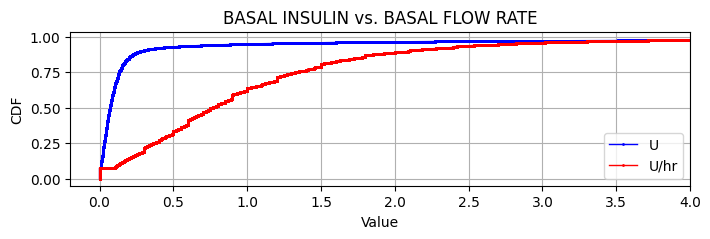

In [40]:
#what is the difference between basals in units and units/h, is there any diff?
plt.figure(figsize=(8,2));ax=plt.gca()
cdf.plot_cdf(facm.loc[facm.FATEST=='BASAL INSULIN'].FAORRES,ax=ax,color='blue',label='U')
cdf.plot_cdf(facm.loc[facm.FATEST=='BASAL FLOW RATE'].FAORRES,ax=ax,color='red',label='U/hr')
ax.set_xlim(-.2,4)
plt.title('BASAL INSULIN vs. BASAL FLOW RATE'); ax.legend()
plt.show()

We see that the deliveries are much smaller indicating that these are the actual deliveries.

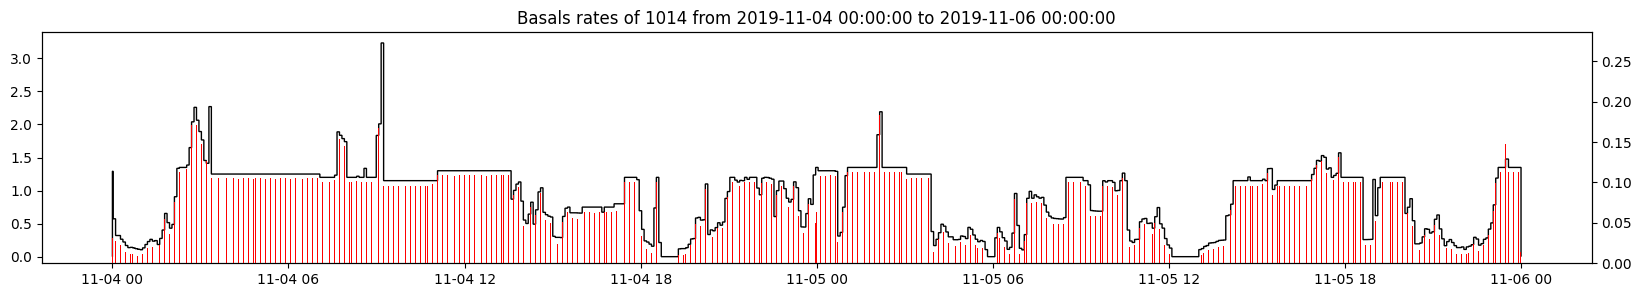

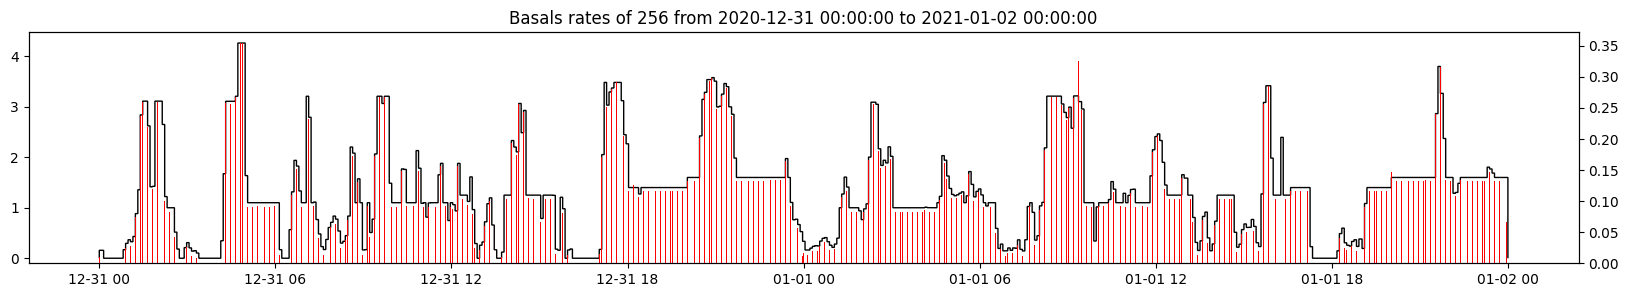

In [59]:
#plot examples for basal flow rates and basal deliveries for 
from src import drawing
from importlib import reload
reload(drawing)

#show an example of a flow rate and a basal within the same subject
#patient_id = np.random.choice(['1542', '1550','1286','389'])
patient_ids = facm.loc[~facm.DXTRT.isin(['MULTIPLE DAILY INJECTIONS'])].USUBJID.sample(2).values
for patient_id in patient_ids:#['1542', '389']:

    sub = facm.loc[(facm.USUBJID==patient_id)&(facm.FATEST.notna())].sort_values('FADTC')
    start = sub.FADTC.min()+timedelta(days=1)
    dur = timedelta(hours=48)
    sub = sub.loc[(sub.FADTC>=start)&(sub.FADTC<=start+dur)]

    sub_flow_rates = sub.loc[sub.FATEST=='BASAL FLOW RATE']
    sub_basals = sub.loc[sub.FATEST=='BASAL INSULIN']
    
    #draw basal delivery rates
    plt.figure(figsize=(20,3)); ax=plt.gca()
    drawing.drawAbsoluteBasalRates(ax,sub_flow_rates.FADTC.values, sub_flow_rates.FAORRES.values,label='U/hr',hatch=None)
    
    #draw individual basal deliveries
    twinx = ax.twinx()
    drawing.drawBoluses(twinx,sub_basals.FADTC, sub_basals.FAORRES,label='U',width=timedelta(minutes=1))
    plt.title(f'Basals rates of {patient_id} from {start} to {start+dur}'); 
    
    # draw Nan deliveries as red xs at zero
    nan_flow_rates = sub_flow_rates.loc[sub_flow_rates.FAORRES.isna()]
    plt.scatter(nan_flow_rates.FADTC, [0]*len(nan_flow_rates), color='red', marker='v', s=100)
    
    # Set ylim to current limits but reduce minimum by 0.1
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0] - 0.1, ylim[1])

Above we saw that the NaN values happen in regions where flow rates are 0. Let's look at a few examples.

In [68]:
#draw examples of rows surrounding nan basal deliveries
sample_nan_delivery_rates = facm.loc[(facm.FATEST=='BASAL FLOW RATE') & (facm.FAORRES.isna())].sample(1)

for row in sample_nan_delivery_rates.itertuples():
    sub = facm.loc[(facm.FATEST=='BASAL FLOW RATE') & (facm.USUBJID == row.USUBJID)].sort_values('FADTC')
    #use iloc to make sure we get the temporal neighbors
    i_loc = sub.index.get_loc(row.Index)
    display(sub.iloc[i_loc-1:i_loc+2])#[['FADTC','FADUR', 'FAORRES']])

,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,DXTRT,ISMDI
1343077,374,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.7,U/hr,2019-12-26 12:12:43,0 days 01:09:57,NaN,NaN,NaN,NaN,TANDEM T:SLIM X2 WITH BASAL IQ,False
1343078,374,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,2019-12-26 13:22:40,0 days 00:10:00,NaN,NaN,NaN,NaN,TANDEM T:SLIM X2 WITH BASAL IQ,False
1343079,374,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.7,U/hr,2019-12-26 13:32:40,0 days 02:30:07,NaN,NaN,NaN,NaN,TANDEM T:SLIM X2 WITH BASAL IQ,False


**Observations:**  
- The basal deliveries happen every 5 minutes and module the basal rate (U/hr) (at least in the example above).
- The NaN values happen in regions where flow rates are 0 and likely mark temporal suspensions.

So, are the delivery rates and individual deliveries equivalent?
  - We can check by calculating the sum (using U/hr and duration) and compare it to the sum obtained on all basal values (U)

##### Comparing basal flow rate and deliveries sums

In [67]:
#compare sums of total basal doses between deliveries and flow rates

# Check if for all Basal flow rates, there is a duration
pump_rows = facm.loc[~facm.ISMDI].copy()
pump_rows['day'] = pump_rows.FADTC.dt.date

print(f"For {100*pump_rows.loc[facm.FATEST=='BASAL FLOW RATE'].FADUR.notna().mean():.2f}% of flow rates (pump only) rows have a duration")

rates_with_dur = pump_rows.loc[pump_rows.FATEST=='BASAL FLOW RATE'].dropna(subset=['FADUR'])
pump_rows['basal_rate'] =  rates_with_dur.FAORRES * rates_with_dur.FADUR.dt.total_seconds()/3600

#compare total daily basal doses
daily_flowrate_sums = pump_rows.groupby(['USUBJID','day'])['basal_rate'].sum()
daily_delivery_sums = pump_rows.loc[pump_rows.FATEST=='BASAL INSULIN'].groupby(['USUBJID','day'])['FAORRES'].sum()

print(f'Total Daily Basal doses are {daily_flowrate_sums.sum():.2f}U (flow rates) {daily_delivery_sums.sum():.2f}U (deliveries)')

#compare daily sum distribution
print(f"The error is:")
display((daily_flowrate_sums-daily_delivery_sums).agg(['mean','std','min','max','sum']))

For 100.00% of flow rates (pump only) rows have a duration
Total Daily Basal doses are 225440.01U (flow rates) 225465.93U (deliveries)
The error is:


mean    -0.002374
std      0.007212
min     -0.073941
max      0.074593
sum    -25.922600
dtype: float64

### ... Summary
- Basal deliveries and flow rates are equivalent
- NaN flow rates likely mark 0 flow rates and should be replaced

### BASAL in MDI patients.
1. Check: Are BASAL FLOW RATES always zero in MDI? 
2. Check: Are BASAL in MDI much larger than in Pump?
3. Check: all BASAL in MDI injections?

In [97]:
#Where does the data sit in MDI
print("Which MDI columns contain valid values?")
def isna(x):
    return x.isna().sum()
r = facm.loc[facm.ISMDI].groupby(['FATEST','FAORRESU'])[['FADTC','FADUR','INSSTYPE','INSNMBOL','INSEXBOL','FAORRES']].agg(['count'])
display(r)
del r


#Check how many BASAL FLOW RATES exists in MDI
mdi_with_flow_rates= facm.loc[facm.ISMDI &(facm.FATEST=='BASAL FLOW RATE')]
print(f'There are {len(mdi_with_flow_rates.USUBJID.unique())} MDI patients with flow rates')
print(f" wich are {100*len(mdi_with_flow_rates)/len(facm.loc[(facm.DXTRT=='MULTIPLE DAILY INJECTIONS')]):.2f}% of the MDI data")
print(f" from these, {mdi_with_flow_rates.FAORRES.count()} are not NaN")


Which MDI columns contain valid values?


,,FADTC,FADUR,INSSTYPE,INSNMBOL,INSEXBOL,FAORRES
,,count,count,count,count,count,count
FATEST,FAORRESU,,,,,,
BASAL FLOW RATE,U/hr,2365,0,0,0,0,0
BASAL INSULIN,U,2365,0,0,0,0,2365
BOLUS INSULIN,U,9515,0,0,0,0,9515


There are 84 MDI patients with flow rates
 wich are 16.60% of the MDI data
 from these, 0 are not NaN


**Observation**: 
- All flow rates in MDI are NaN? 
- It is unclear where these come from
- Values in all other insulin relevant columns are also NaN


Assumption: We can probably drop the FLOW rates for MDI.


Let's check if the total bolus and basal doses match are similar between pump and mdi users 

#### MDI vs. Pump Doses

In [101]:
#calculate average total daily bolus and basal dose per group

facm['day'] = facm.FADTC.dt.date

#sum per FATEST type
#remove BASAL FLOW RATES from the dataset assuming that they reflect the same as the sum of BASAL INSULIN deliveries for Pump users (they are Nan for MDI any way)
temp = facm.loc[facm.FATEST!='BASAL FLOW RATE']
r = temp.groupby(['ISMDI','FATEST','USUBJID','day'])[['FAORRES']].agg('sum')
#bolus, basal per day
#display(r.sample(3))

#sum per day
daily_sum = r.sum(axis=1)
#display(daily_sum.sample(3))

#mean basal/bolus
group_mean = daily_sum.groupby(level=[0, 1]).mean()
display(group_mean)

ISMDI  FATEST       
False  BASAL INSULIN    20.650845
       BOLUS INSULIN    20.226764
True   BASAL INSULIN    19.176018
       BOLUS INSULIN    18.187278
dtype: float64

(-1.0, 50.0)

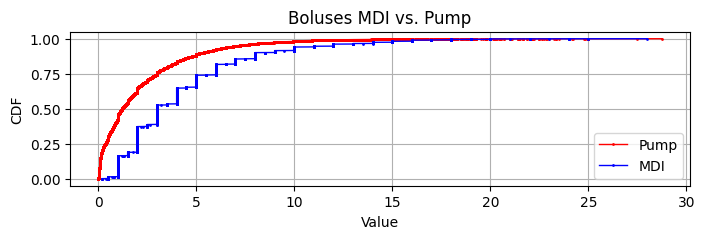

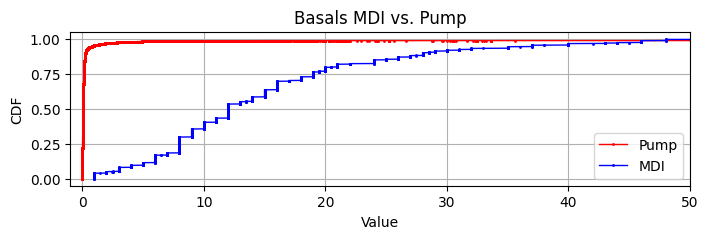

In [100]:
#let's compare the dose sizes
daily_sum_patient = daily_sum.groupby(level=[0,1,2]).mean()
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(facm.loc[(~facm.ISMDI)&(facm.FATEST=='BOLUS INSULIN')].FAORRES,ax=ax,label='Pump',color='red')
cdf.plot_cdf(facm.loc[(facm.ISMDI)&(facm.FATEST=='BOLUS INSULIN')].FAORRES,ax=ax,label='MDI',color='blue')

ax.legend(); ax.set_title('Boluses MDI vs. Pump')
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(facm.loc[(~facm.ISMDI)&(facm.FATEST=='BASAL INSULIN')].FAORRES,ax=ax,label='Pump',color='red')
cdf.plot_cdf(facm.loc[(facm.ISMDI)&(facm.FATEST=='BASAL INSULIN')].FAORRES,ax=ax,label='MDI',color='blue')
ax.legend(); ax.set_title('Basals MDI vs. Pump');ax.set_xlim(-1,50)

- All BASAL in MDI are of much larger value (indicating injections)

#### Bolus Columns

We know that insulin boluses can end up in FAORRES but also in INSNMBOL (normal boluses) and INSEXBOL (extended boluses).

The expectation is that FAORRES carries the sum of the INMBOL and INSEXBOL.  
Can we rely on this or do some boluses not end up in here?

In [114]:
#How many of the 3 columns INSEXBOL INSNMBOL FAORRES carry values?
print('Number of values with values in more than one of the columns INSEXBOL, INSNMBOL, FAORRES')

bolus_rows = facm.loc[(facm.FATEST=='BOLUS INSULIN')]
print('\nPUMP:')
display(bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1).value_counts().sort_index())

print('\nMDI:')
display(bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1).value_counts().sort_index())

Number of values with values in more than one of the columns INSEXBOL, INSNMBOL, FAORRES

PUMP:


1    29463
2    80626
3     2633
Name: count, dtype: int64


MDI:


1    29463
2    80626
3     2633
Name: count, dtype: int64

We see that for pump values, we often have only 1 value. So the assumption that FAORRESS is the sum of the other two must be wrong or at least there are exceptions.

In [167]:
#check for Rows with only 1 value
for num_vals in [1,2,3]:
    temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) == num_vals]
    print(f'{100*len(temp)/len(bolus_rows):.2f}% of rows have {num_vals} columns with values')
    display(temp[['INSEXBOL','INSNMBOL','FAORRES']].count())

26.14% of rows have 1 columns with values


INSEXBOL        0
INSNMBOL        0
FAORRES     29463
dtype: int64

71.53% of rows have 2 columns with values


INSEXBOL      350
INSNMBOL    80276
FAORRES     80626
dtype: int64

2.34% of rows have 3 columns with values


INSEXBOL    2633
INSNMBOL    2633
FAORRES     2633
dtype: int64

Let's check if there is a difference in insulin types between these cases

In [169]:
#check breakdown of source and insulin types
for num_vals in [1,2,3]:
    print(f'\n\nRows with {num_vals} columns carrying values: ..')
    temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) == num_vals]
    #display(temp.FATEST.value_counts())
    display(temp.value_counts(['FATEST','INSDVSRC','INSSTYPE'],dropna=False,sort=False))



Rows with 1 columns carrying values: ..


FATEST         INSDVSRC    INSSTYPE                  
BOLUS INSULIN  Injections  NaN                            9516
               Pump        automatic bolus/correction       26
                           combination                      46
                           dual (normal part)                1
                           dual (square part)                1
                           normal                        19799
                           square                            1
                           standard                         27
                           standard/correction              46
Name: count, dtype: int64



Rows with 2 columns carrying values: ..


FATEST         INSDVSRC  INSSTYPE 
BOLUS INSULIN  Pump      automated     1619
                         normal       78657
                         square         350
Name: count, dtype: int64



Rows with 3 columns carrying values: ..


FATEST         INSDVSRC  INSSTYPE   
BOLUS INSULIN  Pump      combination       2
                         dual/square    2631
Name: count, dtype: int64

Not clear, now let's check if at least the sums match up.

In [156]:
#Let's check if the sums match if there is at least one other value in the other columns
temp = bolus_rows.loc[bolus_rows[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) > 1].copy()
temp = temp[['INSEXBOL','INSNMBOL','FAORRES']].fillna(0) # this makes sure the sum does not result in NaN if only ISNMBOL or INSEXBOL has a value
r = temp.FAORRES - (temp.INSEXBOL+temp.INSNMBOL)
print(r.agg(['count','mean','std','min','max','sum']))

count    8.325900e+04
mean     7.214836e-07
std      1.192128e-04
min     -4.900000e-04
max      5.000000e-04
sum      6.007000e-02
dtype: float64


Yes, they match exactly. 
Last thought: could the rows that have only values in FAORRES be duplicated reports?

In [163]:
#check if there are any boluses reported multiple times. Since we know that FAORRESS always contians the sum, we need to check for duplicates on that column
print(f"{bolus_rows.duplicated(subset=['USUBJID','FADTC','FAORRES']).sum()} duplicated boluses")

0 duplicated boluses


**Findings**
- faorres always contains a value (total dose)
- often these are spolit into the other two columns INSEXBOL or INSMBOL however not always!
-  Many boluses don't end up in the INMBOL and INSEXBOL columns
    - The insulin types are not decisive for this, it probably depends on the pump.
- There are no duplicated boluses


## Collected Questions & Answers

**Answered Questions**  
- The script only considers FATEST == 'BASAL INSULIN' thus ignoring BASAL FLOW RATE. Is this correct?
      - This is because flow rates are equivalent to the deliveries
- Why is FASTRES Nan when FAORRESU is U/hr but not when it is U?
  - This is because FASTRES represents a standard unit and U/hr is not supported, use the original unit FAORRESU instead.
- There are no 0 FASTRESN values but many NaN. How are 0 basal rates reported?
  - It appears as if NaN Basal Flow Rates (at least for Pump users) mark zero values. 

- Why are some boluses only in FAORRES but not in INSNMBOL and INSEXBOL
  - It appears as if these boluses were not properly classified. This is true for at least 26% of the boluses
  - However, it is unclear why.


**Open Questions:**  
- AID
  - Why are `TANDEM T:SLIM X2 WITH BASAL IQ` not considered AID?
  - How do we know if Pump was running AID or not?
- BASAL
    - Why are there many rows with NaN values in `FASTRESN` for FATEST being BASAL INSULIN or BASAL FLOW RATE?
- Why are there MDI patients with basal flow Rates
  - The values are NaN but we don't know why there are these empty rows.
